In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Solve gpu issue for pytorch
# https://discuss.pytorch.org/t/pytorch-1-8-0-fasterrcnn-resnet50-fpn-error/114150/11

In [3]:
import numpy as np
import cv2
import os
import re

# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

/home/yizhou/miniconda3/envs/rlgpu/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
from dataset import HandleDataset, get_train_transform, collate_fn

In [ ]:
full_dataset = HandleDataset("/home/yizhou/Research/temp/", num_frames = 5, \
                              transforms = get_train_transform()) #

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


In [ ]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
len(train_dataset), len(val_dataset)

# Model

In [6]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [7]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# Train

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
num_epochs = 20

from tqdm.auto import tqdm

best_val_loss = 1e4

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    print("epoch", epoch)
    
    # Validation
    model.train()
    # model.eval() #!!!!
    val_loss_list = []
    for images, targets, image_ids in tqdm(val_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        # print("loss_dict", loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        val_loss_list.append(losses.item())
    
    val_loss = np.mean(val_loss_list)
    print("validation loss: ", val_loss)
    
    if val_loss < best_val_loss:
        model_path = '/home/yizhou/Research/temp0/fasterrcnn_resnet50_fpn.pth'
        torch.save(model.state_dict(), model_path)
        best_val_loss = val_loss
    
    # Train
    model.train()
    for images, targets, image_ids in tqdm(train_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # if itr % 50 == 0:
        #     print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
   
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

# Validation

In [ ]:
model.load_state_dict(torch.load(model_path))

In [ ]:
images, targets, image_ids = next(iter(val_data_loader))

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Test

In [9]:
model_path = '/home/yizhou/Research/temp0/fasterrcnn_resnet50_fpn.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [40]:
image_path = "/home/yizhou/Research/temp0/4/rgb_0.png"

In [41]:
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

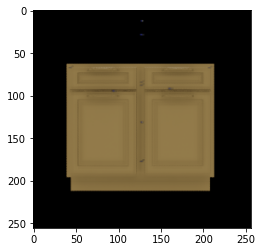

In [42]:
plt.imshow(image)

In [43]:
images = [torch.tensor(image).permute(2,0,1).to("cuda")]

In [44]:
images[0].shape

torch.Size([3, 256, 256])

In [45]:
model.eval()
outputs = model(images)

In [46]:
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

In [47]:
boxes, scores

(array([[158.095   ,  99.31419 , 183.69576 , 102.170074],
        [ 69.824005,  98.818504,  95.528496, 101.89911 ],
        [125.44823 ,  83.461655, 130.60254 ,  88.80748 ],
        [125.79515 , 130.57504 , 129.90018 , 133.68959 ],
        [125.36621 , 175.74435 , 130.90672 , 179.0695  ],
        [124.60831 ,  27.076529, 130.88023 ,  30.5035  ],
        [156.87947 ,  67.25545 , 180.86076 ,  69.66854 ],
        [ 69.605644,  67.47182 ,  97.4993  ,  69.727554],
        [124.414185,  11.277105, 130.61728 ,  14.750123],
        [161.25694 ,  99.06365 , 181.14658 , 101.18144 ],
        [124.70224 , 175.41692 , 131.13701 , 182.32172 ],
        [ 70.52164 ,  98.28958 ,  94.548065, 100.4005  ],
        [125.088646, 130.00768 , 130.46599 , 136.06847 ]], dtype=float32),
 array([0.94060904, 0.9357937 , 0.9300206 , 0.8545453 , 0.79771066,
        0.74421114, 0.59553945, 0.5863084 , 0.33922637, 0.22888093,
        0.11539952, 0.07477338, 0.06911936], dtype=float32))

In [48]:
boxes = boxes[scores >= 0.8].astype(np.int32)

In [49]:
boxes

array([[158,  99, 183, 102],
       [ 69,  98,  95, 101],
       [125,  83, 130,  88],
       [125, 130, 129, 133]], dtype=int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


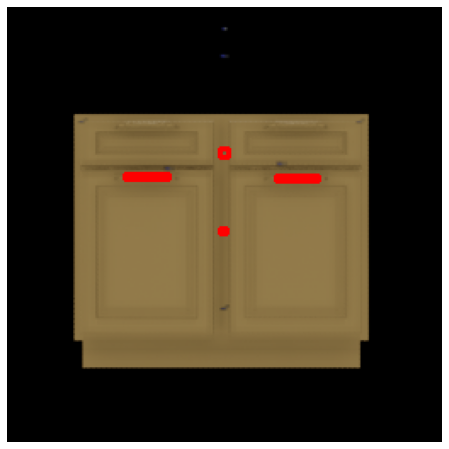

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(image)

In [51]:
def get_bbox_world_position(box, 
       resolution = 256, D = -293, camera_pos = [-1, 0, 0.5], handle_x = 0.61857):
    """
    Calculate the grasp location for the handle

    box: [x_min, y_min, x_max, y_max] 2D boudning box in camera
    resolution: camera resolution
    D: depth of field
    camera_pos: camera_position
    handle_x: object offset

    """
    w_min = box[0] - resolution / 2
    w_max = box[2] - resolution / 2
    h_min = box[1] - resolution / 2
    h_max = box[3] - resolution / 2

    y_max = (handle_x - camera_pos[0]) * w_min / D + camera_pos[1]
    y_min = (handle_x - camera_pos[0]) * w_max / D + camera_pos[1]

    z_max = (handle_x - camera_pos[0]) * h_min / D + camera_pos[2]
    z_min = (handle_x - camera_pos[0]) * h_max / D + camera_pos[2]


    return [y_min, y_max, z_min, z_max]


In [ ]:
get_bbox_world_position(boxes[0])

In [ ]:
boxes[0]